In [1]:
import numpy as np
import numpy.matlib
from numpy.matlib import repmat
import math as m
import os
from scipy.linalg import toeplitz
from scipy.special import gamma
from scipy.interpolate import interp1d
import scipy.sparse
import scipy
from YC_fcbt import *
from dif1D import *
from fit_circle_through_3_points import *
import matplotlib.pyplot as plt

In [12]:
# physical parameters
sigma = 100;       # surface tension [mN/m]
grav = 9.807e3;    # gravitational acceleration [mm/s^2]
rneedle = 1;       # radius of the needle [mm]
volume0 = 32;      # prescribed volume in mm^3
deltarho = 1e-3;   # density difference [10^6 kg/m^3]
pi=m.pi

# numerical parameters
N = 40;          # resolution of the discretization for calculation
Nplot = 80;      # resolution of the discretization for plotting
Ncheb = 10;      # number of Chebyshev to describe the shape
alpha = 0.1;     # relaxation parameter in the Newton-Raphson scheme

# calculate the dimensionless quantities
sigmaprime = sigma/(deltarho*grav*rneedle**2)
volume0prime = volume0/rneedle**3


def rms(y) :
    rms = np.sqrt(np.mean(y**2))
    return rms

In [13]:
# if !! deltarho*grav*volume0/(2*m.pi*sigma*rneedle) > 0.14:
# predict the maximum length of the interface (empirical Nagel)
smax = m.sqrt(sigmaprime)*2.0/0.8701
# get the differentation/integration matrices and the grid
D,_,w,s = dif1D('cheb',0,smax,N,5)
# predict the shape of the interface (empirical Nagel)
z = -4/3*smax/pi*(np.cos(pi*3/4*s/smax))
z = z - max(z)
r = 4/3*smax/pi*(np.sin(pi*3/4*s/smax))
psi = pi*3/4*s/smax
C = 1; # initial stretch parameter
p0 = m.sqrt(sigmaprime)*1.5; # predict the pressure (empirical Nagel)

Z = np.zeros((N,N));            # matrix filled with zeros
IDL = np.hstack((1, np.zeros((N-1)))); # line with single one and rest zeros
ZL = np.zeros(N);       # line completely filled with zeros
u = np.ones((3*N+2,1)); 
b = np.ones((3*N+2,1)); # solution vector and right hand side
iter = 0; crash = 0; 

In [9]:
# physical parameters
sigma = 100;       # !!! surface tension [mN/m]
grav = 9.807e3;    # gravitational acceleration [mm/s^2]
rneedle = 1;       # radius of the needle [mm]
volume0 = 8;      # !!! prescribed volume in mm^3
deltarho = 1e-3;   # density difference [10^6 kg/m^3]
pi=m.pi

# numerical parameters
N = 40;          # resolution of the discretization for calculation
Nplot = 80;      # resolution of the discretization for plotting
Ncheb = 10;      # number of Chebyshev to describe the shape
alpha = 0.1;     # relaxation parameter in the Newton-Raphson scheme

# calculate the dimensionless quantities
sigmaprime = sigma/(deltarho*grav*rneedle**2)
volume0prime = volume0/rneedle**3


#change sigma and volume0
print(deltarho*grav*volume0/(2*m.pi*sigma*rneedle) > 0.14)

# find the roots for the polynomial of a spherical cap
rts = np.roots([pi/6 ,0 ,pi/2 ,-volume0prime])    
h0 = np.real(rts[2])

ABC=np.array(np.vstack(((1,0),(0,-h0),(-1,0))))
Rguess,xcyc = fit_circle_through_3_points(ABC)

# get the opening angle of the circle
if xcyc[1] < 0:
  theta = m.acos(1/Rguess)
else:
  theta = -m.acos(1/Rguess)

    
# predict the maximum length of the interface
smax = Rguess*(2*theta+m.pi)
# get the differentation/integration matrices and the grid
D,_,w,s = dif1D('fd',0,smax,N,5)

# start- and end-point of the current radial line
dtheta = np.linspace(-m.pi/2,theta,N)
dtheta = dtheta.T
r = xcyc[0] + Rguess*np.cos(dtheta)
z = xcyc[1] + Rguess*np.sin(dtheta)


psi = np.arctan2(np.dot(D,z),np.dot(D,r))
 
C = 1;                      # initial stretch parameter
p0 = 2*Rguess*sigmaprime;   # predict the pressure

# get the differentation/integration matrices and the grid
D,_,w,s = dif1D('cheb',0,smax,N,5)

False


range(20, 30)


In [14]:
while rms(u) > 1e-10:

  iter = iter + 1
  
  if iter > 1200 :
    print('iter > 1200!')
    crash = 1; break
  
  # determine r from psi
  A11 = C*D; 
  A13 = np.diag(np.squeeze(np.sin(psi)))
  A18 = np.dot(D,r); 
  b1 = -(C*np.dot(D,r)-np.cos(psi))
  # determine z from psi 
  A22 = C*D; 
  A23 = np.diag(np.squeeze(-np.cos(psi))); 
  A28 = np.dot(D,z)
  b2 = -(C*np.dot(D,z)-np.sin(psi))

  # determine psi from Laplace law
  
  A31 = -sigmaprime*np.diag(np.squeeze(np.sin(psi)/r**2))
  A32 = np.diag(np.squeeze(np.ones(N)))
  A33 = C*sigmaprime*D + sigmaprime*np.diag(np.squeeze(np.cos(psi)/r))
  A38 = sigmaprime*(np.dot(D,psi))
  A39 = -np.ones(N)
  b3 = p0-z-sigmaprime*(C*np.dot(D,psi)+np.sin(psi)/r)

  # impose the needle radius as a BC (imposes the domain length)
  # NOTE: the lengths are scaled with the radius, thus its value is one

  A81 = np.flip(IDL).reshape(1,N); 
  b8 = (1-r[-1])

    # determine pressure - use volume
  A91 = 2*w*r.T*np.sin(psi.T)
  A93 = w*r.T**2*np.cos(psi.T)
  A98 = np.array(-volume0prime/m.pi).reshape(1,1)
  b9 = -(np.dot(w,(r**2*np.sin(psi)))-C*volume0prime/m.pi)

  # boundary condition r(0) = 0
  A11[0,:] = IDL; 

  A13[0,:] = ZL; 
  A18[0] = 0
  b1[0] = -r[0]

  # boundary condition z(s0) = 0
  A22[0,:] = np.flip(IDL); 
  A23[0,:] = ZL; 
  A28[0] = 0
  b2[0] = -z[-1]

  # boundary condition phi(0) = 0
  A31[0,:] = ZL; 
  A32[0,:] = ZL; 
  A33[0,:] = IDL; 
  A38[0,:] = 0; 
  A39[0] = 0
  A39=A39.reshape(N,1)
  b3[0] = -psi[0]

  # assemble matrices
  Z1 = np.zeros(N).reshape(N,1)

  # use for debug
  #A_0=np.hstack((A11, Z, A13, A18, Z1))
  #A_1=np.hstack((Z, A22, A23, A28, Z1))
  #A_2=np.hstack((A31, A32, A33, A38, A39))
  #A_3=np.hstack((A81, np.zeros((1,2*N)), np.array(-1).reshape(1,1), np.array(0).reshape(1,1)))
  #A_4=np.hstack((A91, Z1.T,A93,A98,np.array(0).reshape(1,1)))

  A = np.vstack((np.hstack((A11, Z, A13, A18, Z1)),
                np.hstack((Z, A22, A23, A28, Z1)),
                np.hstack((A31, A32, A33, A38, A39)),
                np.hstack((A81, np.zeros((1,2*N)), np.array(-1).reshape(1,1), np.array(0).reshape(1,1))),
                np.hstack((A91, Z1.T,A93,A98,np.array(0).reshape(1,1)))))

  b = np.vstack((b1,b2,b3,b8,b9)); 

  # solve the system of equations
  u = np.linalg.inv(A).dot(b)

  # update variables
  r   = r   + alpha*u[0:N]
  z   = z   + alpha*u[N:2*N]; 
  psi = psi + alpha*u[2*N:3*N]; 
  C   = C   + alpha*u[3*N]; 
  p0  = p0  + alpha*u[3*N]; 
 
  if rms(b) > 1e3:
    crash = 1; break; 

C:\Users\臧义程\AppData\Local\Temp\ipykernel_31184\3392818823.py:22: RuntimeWarning: invalid value encountered in divide
  A31 = -sigmaprime*np.diag(np.squeeze(np.sin(psi)/r**2))
C:\Users\臧义程\AppData\Local\Temp\ipykernel_31184\3392818823.py:24: RuntimeWarning: divide by zero encountered in divide
  A33 = C*sigmaprime*D + sigmaprime*np.diag(np.squeeze(np.cos(psi)/r))
C:\Users\臧义程\AppData\Local\Temp\ipykernel_31184\3392818823.py:27: RuntimeWarning: invalid value encountered in divide
  b3 = p0-z-sigmaprime*(C*np.dot(D,psi)+np.sin(psi)/r)


iter > 1200!


In [ ]:
# determine r from psi
A11 = C*D; 
A13 = np.diag(np.squeeze(np.sin(psi)))
A18 = np.dot(D,r); 
b1 = -(C*np.dot(D,r)-np.cos(psi))
# determine z from psi 
A22 = C*D; 
A23 = np.diag(np.squeeze(-np.cos(psi))); 
A28 = np.dot(D,z)
b2 = -(C*np.dot(D,z)-np.sin(psi))

 # determine psi from Laplace law
 
A31 = -sigmaprime*np.diag(np.squeeze(np.sin(psi)/r**2))
A32 = np.diag(np.squeeze(np.ones(N)))
A33 = C*sigmaprime*D + sigmaprime*np.diag(np.squeeze(np.cos(psi)/r))
A38 = sigmaprime*(np.dot(D,psi))
A39 = -np.ones(N)
b3 = p0-z-sigmaprime*(C*np.dot(D,psi)+np.sin(psi)/r)

  # impose the needle radius as a BC (imposes the domain length)
  # NOTE: the lengths are scaled with the radius, thus its value is one

A81 = np.flip(IDL).reshape(1,N); 
b8 = (1-r[-1])
  
  # determine pressure - use volume
A91 = 2*w*r.T*np.sin(psi.T)
A93 = w*r.T**2*np.cos(psi.T)
A98 = np.array(-volume0prime/m.pi).reshape(1,1)
b9 = -(np.dot(w,(r**2*np.sin(psi)))-C*volume0prime/m.pi)

# boundary condition r(0) = 0
A11[0,:] = IDL; 

A13[0,:] = ZL; 
A18[0] = 0
b1[0] = -r[0]
  
# boundary condition z(s0) = 0
A22[0,:] = np.flip(IDL); 
A23[0,:] = ZL; 
A28[0] = 0
b2[0] = -z[-1]
  
# boundary condition phi(0) = 0
A31[0,:] = ZL; 
A32[0,:] = ZL; 
A33[0,:] = IDL; 
A38[0,:] = 0; 
A39[0] = 0
A39=A39.reshape(N,1)
b3[0] = -psi[0]

# assemble matrices
Z1 = np.zeros(N).reshape(N,1)

# use for debug
#A_0=np.hstack((A11, Z, A13, A18, Z1))
#A_1=np.hstack((Z, A22, A23, A28, Z1))
#A_2=np.hstack((A31, A32, A33, A38, A39))
#A_3=np.hstack((A81, np.zeros((1,2*N)), np.array(-1).reshape(1,1), np.array(0).reshape(1,1)))
#A_4=np.hstack((A91, Z1.T,A93,A98,np.array(0).reshape(1,1)))

A = np.vstack((np.hstack((A11, Z, A13, A18, Z1)),
              np.hstack((Z, A22, A23, A28, Z1)),
              np.hstack((A31, A32, A33, A38, A39)),
              np.hstack((A81, np.zeros((1,2*N)), np.array(-1).reshape(1,1), np.array(0).reshape(1,1))),
              np.hstack((A91, Z1.T,A93,A98,np.array(0).reshape(1,1)))))
     
b = np.vstack((b1,b2,b3,b8,b9)); 

# solve the system of equations
u = np.linalg.inv(A).dot(b)

# update variables
r   = r   + alpha*u[0:N]
z   = z   + alpha*u[N:2*N]; 
psi = psi + alpha*u[2*N:3*N]; 
C   = C   + alpha*u[3*N]; 
p0  = p0  + alpha*u[3*N+1]; 


In [26]:
print('volume = ', round(float(np.dot(rneedle**3*pi*w,(r**2*np.sin(psi))/C)),12),' mm^3')
print('area = ', round(float(np.dot(rneedle**2*pi*2*w,(r)/C)),12),' mm^2')
print('pressure = ', round(float(deltarho*grav*rneedle*p0),12),' Pa')

volume=round(float(np.dot(rneedle**3*pi*w,(r**2*np.sin(psi))/C)),12)
area=round(float(np.dot(rneedle**2*pi*2*w,(r)/C)),12)
pressure=round(float(deltarho*grav*rneedle*p0),12)


path="./v%.2f_a%.2f_p%.2f.jpg" %(volume, area, pressure)


volume =  32.0  mm^3
area =  46.438425386395  mm^2
pressure =  50.295468081645  Pa
./v32.00_a46.44_p50.30.jpg


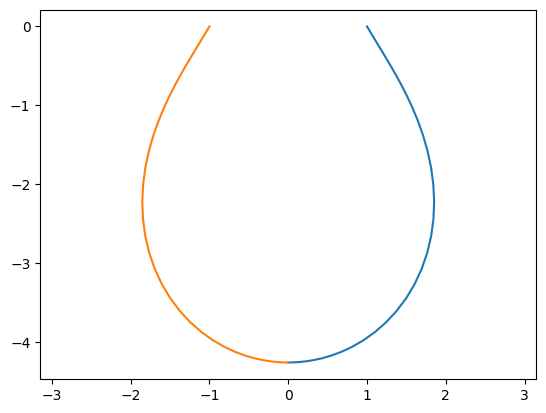

In [25]:
s_a=np.squeeze(s,axis=1)
r_a=np.squeeze(r,axis=1)
z_a=np.squeeze(z,axis=1)

fig = plt.figure(path)
plt.plot(r_a,z_a)
plt.plot(-r_a,z_a)
plt.axis('equal')
axes=plt.gca()
plt.savefig(path)



In [ ]:


ss = np.linspace(float(s[0]),float(s[-1]),Nplot)

rr = interp1d(s.T,ss)
zz = interp1d(s,z,ss,'cubic')


In [ ]:
print(s.shape)
print(ss.shape)
print(r.shape)
print(len(ss))
ss_a=ss.reshape(1,len(ss))

In [ ]:
s_a=np.squeeze(s,axis=1)
r_a=np.squeeze(r,axis=1)




rr = interp1d(s_a,r_a,kind='cubic',fill_value=ss_a)


In [ ]:
f=0
N=len(y)
pi=m.pi
y=r
max_order=10

smax = m.sqrt(sigmaprime)*2.0/0.8701

# get the differentation/integration matrices and the grid
D,_,w,s = dif1D('cheb',0,smax,N,5)
# predict the shape of the interface (empirical Nagel)
z = -4/3*smax/m.pi*(m.cos(m.pi*3/4*s/smax))
z = z - max(z)
r = 4/3*smax/m.pi*(m.sin(m.pi*3/4*s/smax))

YC=fcbt('cheb',N,abs(max_order)+1)
if np.size(y,1)==1:
    y=y.T
ys0=y
if max_order == None:
    max_order=N/2
if shift_order == None:
    shift_order = 0
revarg = (max_order<0)
max_order=abs(max_order)
ds=2/N-1
d,_,w,s=dif1D('fd',-1+ds,2-2*ds,N-2,5)
d[0,:]=np.hstack((1,np.zeros(N-3)))
w2= np.linalg.inv(d)
w2=w2[-1,:]
w2[0]=0
c=np.zeros((max_order+1,1))
# 1st pass over 6 modes, c are the modes, from y the fitted part is subtracted
for k in range (0,min(6,max_order)+1):
    y0 = YC [0,k]*y[0]
    dy=(YC[1,k]*y(1)-YC[0,k]*y[0])/ds
    singular_left = (y0+dy)*np.acos(1-ds)-dy*np.sqrt(ds*(2-ds))
    y0 = YC[-1,k]*y[-1]
    dy = (YC[-1,k]*y[-1]-YC[-2,k]*y[-2])/ds
    singular_right = (y0-dy)*np.acos(1-ds)+dy*np.sqrt(ds*(2-ds))
    c[k] = 2/pi*(w2*(y[1:-2]/np.sqrt(1-s**2)*YC[1:-2,k]) + singular_left + singular_right)/(1+(k==0))
    y = y - c[k]*YC[:,k]

